# CEIA - Análisis de Datos
## Trabajo Práctico Número 2

### Grupo: 

          - Martín A. Brocca 
          - Agustín A. Lopez Fredes 

Dataset seleccionado: [AirBnB Dataset](https://insideairbnb.com/get-the-data/)

In [1]:
# importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import geopandas as gpd
from shapely.geometry import Point
import missingno as msno



#### De acuerdo a lo realizado en el TP1, el problema seleccionado cuenta con un dataset conformado por 7 archivos:
| **Archivo**                | **Descripción**                                                                 |
|------------------------|------------------------------------------------------------------------------|
| Listing.csv.gz         | Listado detallado de inmuebles                                               |
| Calendar.csv.gz        | Información detallada de fechas de reserva y ocupación                       |
| Reviews.csv.gz         | Listado detallado de opiniones y valoraciones de usuarios                    |
| Listing.csv            | Versión resumida del listado de inmuebles para facilitar visualizaciones     |
| Neighbourhoods.csv     | Listado de barrios de la localidad                                           |
| Neighbourhoods.geojson | Archivo GeoJson con los barrios de la localidad                              |


El dataset corresponde a los últimos 12 meses a cierre de Enero 2025.

Se utilizarán los archivos detallados para el EDA, como así también el archivo geojson para la representación gráfica de algunas conclusiones o reportes.


In [2]:
#  URL para descargar todos los archivos que conforman el dataset
data_base_url = "https://data.insideairbnb.com/argentina/ciudad-aut%C3%B3noma-de-buenos-aires/buenos-aires/2025-01-29"


# Definimos los nombres de los archivos y sus correspondientes URLs
data_files = {
    "df_listings_details": "/data/listings.csv.gz",
    "df_reviews_details": "/data/reviews.csv.gz",
    "df_calendar": "/data/calendar.csv.gz",
    "df_listings": "/visualisations/listings.csv",
    "df_reviews": "/visualisations/reviews.csv",
    "df_neighbourhoods": "/visualisations/neighbourhoods.csv",
}


# Carga directa de los archivos CSV desde la URL
dfs = {
    #name: pd.read_csv(base_url + filename, compression="gzip" if filename.endswith(".gz") else None)
    name: pd.read_csv(data_base_url + filename)
    for name, filename in data_files.items()
}
# Carga del archivo GeoJSON
dfs["df_neighbourhoods_geojson"] = gpd.read_file(
    data_base_url + "/visualisations/neighbourhoods.geojson"
)


In [3]:
# Creación de las variables individuales.
df_listings_details = dfs["df_listings_details"]
df_neighborhoods = dfs["df_neighbourhoods"]
df_reviews_details = dfs["df_reviews_details"]
df_calendar = dfs["df_calendar"]

Para el caso de listings, debido a que el dataset cuenta con 45 columnas, en el TP1 determinamos aquellas de interés:

In [ ]:
df_listings_details_interes = df_listings_details[['id','property_type', 'room_type', 
                                           'name', 'description','accommodates', 'bedrooms', 'beds', 
                                            'bathrooms','price', 'availability_eoy',
                                            'estimated_occupancy_l365d', 'review_scores_rating',
                                            'review_scores_accuracy', 'review_scores_cleanliness',                                                     'review_scores_checkin', 'review_scores_communication',
                                            'review_scores_location','latitude', 'longitude', 
                                            'review_scores_value','number_of_reviews','reviews_per_month', 
                                            'neighbourhood', 'neighbourhood_cleansed',
                                            'host_about', 'host_location', 'host_neighbourhood', 'host_listings_count',
                                            'host_identity_verified', 'host_has_profile_pic']]

Queremos predecir el nivel de ocupación que tendrá cada propiedad, por lo que el target será el nivel de disponibilidad anual de los listings ('availability_eoy'). Esta variable muestra la cantidad de días que una propiedad estuvo disponible en el año, por lo que es el complemento de la ocupación.

En el TP1 se analizaron los valores faltantes y outliers. Reutilizamos esas funciones para determinar el tratamiento de estas columnas, pero en el caso de imputaciones, haremos el fit con un conjunto de train para luego aplicarlo a test:

In [5]:
# Función para informar las columnas con mayor cantidad de datos faltantes orderadas de mayor a menor
def report_missing(df):
    missing_report = (
        df.isnull().sum()
        .to_frame(name='missing_count')
        .assign(missing_pct=lambda x: (x['missing_count'] / len(df)) * 100)
        .query("missing_count > 0")
        .sort_values(by='missing_count', ascending=False)
    )
    return missing_report

In [6]:
# Función auxiliar para detectar outliers
def detectar_outliers(df):
    # Seleccionar solo columnas numéricas
    columnas_numericas = df.select_dtypes(include=[np.number]).columns
    results = []

    for col in columnas_numericas:
        # Calcular IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Límites para IQR con umbral 1.5
        limite_inferior_iqr_1_5 = Q1 - 1.5 * IQR
        limite_superior_iqr_1_5 = Q3 + 1.5 * IQR
        
        # Límites para IQR con umbral 3 (outliers severos)
        limite_inferior_iqr_3 = Q1 - 3 * IQR
        limite_superior_iqr_3 = Q3 + 3 * IQR

        # Calcular media y desviación estándar (umbral fijo de 3)
        mean = df[col].mean()
        std = df[col].std()
        limite_inferior_std = mean - 3 * std
        limite_superior_std = mean + 3 * std

        # Identificar outliers
        outliers_iqr_1_5 = df[(df[col] < limite_inferior_iqr_1_5) | (df[col] > limite_superior_iqr_1_5)]
        outliers_iqr_3 = df[(df[col] < limite_inferior_iqr_3) | (df[col] > limite_superior_iqr_3)]
        outliers_std = df[(df[col] < limite_inferior_std) | (df[col] > limite_superior_std)]

        # Calcular porcentajes
        total_data_points = len(df[col].dropna())
        outlier_percentage_iqr_1_5 = (len(outliers_iqr_1_5) / total_data_points) * 100 if total_data_points > 0 else 0
        outlier_percentage_iqr_3 = (len(outliers_iqr_3) / total_data_points) * 100 if total_data_points > 0 else 0
        outlier_percentage_std = (len(outliers_std) / total_data_points) * 100 if total_data_points > 0 else 0

        # Guardar resultados
        results.append({
            'Columna': col,
            'Porcentaje Outliers (Umbral 1.5 * IQR)': round(outlier_percentage_iqr_1_5, 2),
            'Porcentaje Outliers Severos (Umbral 3 * IQR)': round(outlier_percentage_iqr_3, 2),
            'Porcentaje Outliers (Umbral 3 * STD)': round(outlier_percentage_std, 2)
        })

    # Convertir resultados a DataFrame
    result_df = pd.DataFrame(results)
    
    # Ordenar por porcentaje de outliers (Umbral 1.5 * IQR) de mayor a menor
    result_df_sorted = result_df.sort_values(by='Porcentaje Outliers (Umbral 1.5 * IQR)', ascending=False)
    
    # Generar gráfico de barras con Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=result_df_sorted,
        x='Columna',
        y='Porcentaje Outliers (Umbral 1.5 * IQR)',
        color='#4e79a7'  # Azul oscuro compatible con temas claros y oscuros
    )
    plt.title('Porcentaje de Outliers por Columna (Umbral 1.5 * IQR)')
    plt.xlabel('Columnas')
    plt.ylabel('Porcentaje de Outliers (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return result_df

In [7]:
report_missing(df_listings_details_interes)

,missing_count,missing_pct
neighbourhood_group_cleansed,35172,100.000000
neighbourhood,18584,52.837484
host_about,16291,46.318094
host_neighbourhood,13451,38.243489
host_location,7553,21.474468
review_scores_accuracy,5761,16.379506
review_scores_value,5761,16.379506
review_scores_location,5760,16.376663
review_scores_rating,5760,16.376663
review_scores_cleanliness,5760,16.376663


In [8]:
report_missing(df_reviews_details)

,missing_count,missing_pct
comments,45,0.004565
reviewer_name,1,0.000101


Concluimos que el listado detallado de reviews no contiene un porcentaje significativo de nulos o faltantes, dado el muy bajo número de filas afectadas, se podría directamente descartarlas sin afectar el dataset en general.

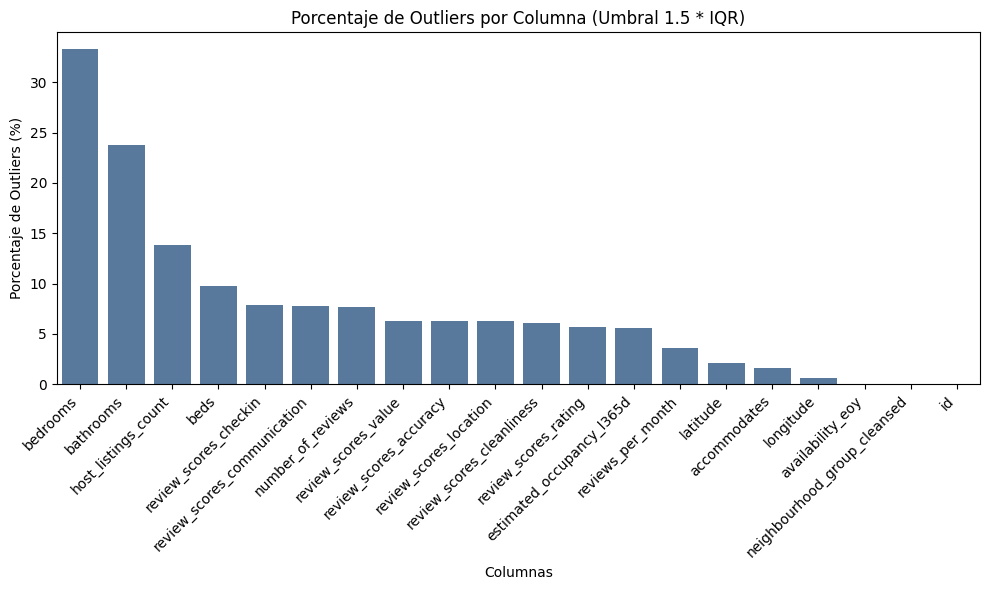

,Columna,Porcentaje Outliers (Umbral 1.5 * IQR),Porcentaje Outliers Severos (Umbral 3 * IQR),Porcentaje Outliers (Umbral 3 * STD)
0,id,0.00,0.00,0.00
1,accommodates,1.58,0.55,1.58
2,bedrooms,33.31,33.31,0.84
3,beds,9.74,2.05,1.20
4,bathrooms,23.74,23.74,1.47
5,availability_eoy,0.00,0.00,0.00
6,estimated_occupancy_l365d,5.62,0.00,0.00
7,review_scores_rating,5.67,1.92,1.66
8,review_scores_accuracy,6.26,3.37,1.60
9,review_scores_cleanliness,6.04,2.04,1.74


In [9]:
porcentaje_outliers_listings = detectar_outliers(df_listings_details_interes)
porcentaje_outliers_listings

Se observa que en general el porcentaje de valores atípicos es bajo, aunque hay variables como bathrooms, bedrooms que contienen un porcentaje elevado según el criterio de IQR, no así por el criterio de la desviación estándar, por lo que procedemos a analizarlos

In [10]:
# Filtrar outliers de precio
# Utilizar criterio de 3 * IQR
Q1_price = df_listings_details_interes['price'].quantile(0.25)
Q3_price = df_listings_details_interes['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
limite_inferior_price = Q1_price - 3 * IQR_price
limite_superior_price = Q3_price + 3 * IQR_price
df_listings_details_filtrado = df_listings_details_interes[
    (df_listings_details_interes['price'] >= limite_inferior_price) &
    (df_listings_details_interes['price'] <= limite_superior_price)
]

plt.figure(figsize=(10, 6))
sns.histplot(data=df_listings_details_filtrado, x='price', bins=50, kde=True)
plt.title('Distribución del precio')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

C:\Users\alope\AppData\Local\Temp\ipykernel_3356\3970739547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_details_filtrado['precio_habitacion'] = df_listings_details_filtrado['price'] / df_listings_details_filtrado['bedrooms']
C:\Users\alope\AppData\Local\Temp\ipykernel_3356\3970739547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_details_filtrado['precio_cama'] = df_listings_details_filtrado['price'] / df_listings_details_filtrado['beds']
C:\Users\alope\AppData\Local\Tem

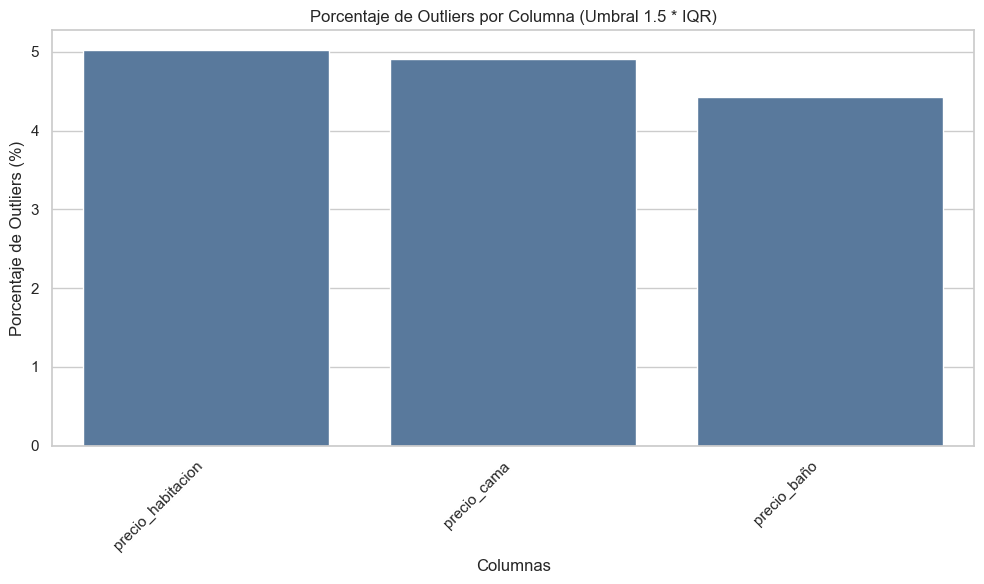

,Columna,Porcentaje Outliers (Umbral 1.5 * IQR),Porcentaje Outliers Severos (Umbral 3 * IQR),Porcentaje Outliers (Umbral 3 * STD)
0,precio_habitacion,5.02,1.31,2.13
1,precio_cama,4.91,1.38,2.07
2,precio_baño,4.43,0.83,1.57


In [ ]:
df_listings_details_filtrado['precio_habitacion'] = df_listings_details_filtrado['price'] / df_listings_details_filtrado['bedrooms']
df_listings_details_filtrado['precio_cama'] = df_listings_details_filtrado['price'] / df_listings_details_filtrado['beds']
df_listings_details_filtrado['precio_baño'] = df_listings_details_filtrado['price'] / df_listings_details_filtrado['bathrooms']

#Descartamos valores infinitos cuando cama, baño o habitacion es 0
df_listings_details_filtrado = df_listings_details_filtrado[(df_listings_details_filtrado['bedrooms'] !=0) & (df_listings_details_filtrado['beds'] !=0) & (df_listings_details_filtrado['bathrooms'] !=0)]

porcentaje_outliers_listings = detectar_outliers(df_listings_details_filtrado[['precio_habitacion', 'precio_cama', 'precio_baño']])
porcentaje_outliers_listings

In [ ]:
df_listings_details_sorted_precio_habitacion = df_listings_details_filtrado.sort_values(by='precio_habitacion', ascending=True)
df_listings_details_sorted_precio_habitacion[['name', 'description', 'bathrooms', 'bedrooms', 'beds','price', 'precio_habitacion', 'precio_baño','review_scores_value']].head(20)

,name,description,bathrooms,bedrooms,beds,price,precio_habitacion,precio_baño,review_scores_value
893,Loft in Downtown - Best location!,LOFT (50m²) located in the CENTER OF BUENOS AI...,1.0,1.0,1.0,260.0,260.000000,260.000000,5.00
3116,"Designer Studio in Belgrano, 5 blocks to Subway",Only 5 blocks from Subway D (José Hernández). ...,1.0,1.0,2.0,600.0,600.000000,600.000000,4.33
28561,Alquiler cuartos en Gran casa,"Great house in Palermo, very well located. Wit...",5.0,14.0,14.0,11762.0,840.142857,2352.400000,NaN
4231,Apart Hotel León Imperial ubicado en Pasco 492.,An Apart Hotel located in the strategic center...,22.0,22.0,4.0,19000.0,863.636364,863.636364,3.71
29274,simple sencillo servicial,Everything you want to explore is steps away f...,20.0,19.0,30.0,17644.0,928.631579,882.200000,NaN
16805,Habitación con baño privado,"Enjoy the simplicity of this quiet, central ho...",1.5,2.0,2.0,2028.0,1014.000000,1352.000000,NaN
1318,Sunny apartment in BA,The apartment has multiple choices to go downt...,1.0,1.0,1.0,1065.0,1065.000000,1065.000000,4.90
33453,Habitación privada | Casa compartida | Palermo,"A shared house in the heart of Palermo, with 1...",3.0,11.0,1.0,11762.0,1069.272727,3920.666667,1.00
1391,Depto 2 Amb a un paso Microcentro,"Comfortable, modernized apartment, in the old ...",1.5,1.0,2.0,1149.0,1149.000000,766.000000,4.71
21548,Private room in shared house | Palermo,"A shared house in the heart of Palermo, with 1...",3.0,11.0,1.0,13800.0,1254.545455,4600.000000,NaN


In [ ]:
df_listings_details_sorted_precio = df_listings_details_filtrado.sort_values(by='precio_cama', ascending=True)
df_listings_details_sorted_precio[['name', 'description', 'bathrooms', 'bedrooms', 'beds','price', 'precio_habitacion', 'precio_baño','review_scores_value']].head(20)

,name,description,bathrooms,bedrooms,beds,price,precio_habitacion,precio_baño,review_scores_value
893,Loft in Downtown - Best location!,LOFT (50m²) located in the CENTER OF BUENOS AI...,1.0,1.0,1.0,260.0,260.000000,260.000000,5.00
3116,"Designer Studio in Belgrano, 5 blocks to Subway",Only 5 blocks from Subway D (José Hernández). ...,1.0,1.0,2.0,600.0,600.000000,600.000000,4.33
1391,Depto 2 Amb a un paso Microcentro,"Comfortable, modernized apartment, in the old ...",1.5,1.0,2.0,1149.0,1149.000000,766.000000,4.71
29274,simple sencillo servicial,Everything you want to explore is steps away f...,20.0,19.0,30.0,17644.0,928.631579,882.200000,NaN
34594,hotel de mochileros,Discover the local gems from this modern home.,3.5,1.0,21.0,15239.0,15239.000000,4354.000000,NaN
6030,"Zona turística Shared Dormitory, Men only #Pod...","Shared rooms with modern and youthful design, ...",2.5,1.0,14.0,11101.0,11101.000000,4440.400000,4.22
28561,Alquiler cuartos en Gran casa,"Great house in Palermo, very well located. Wit...",5.0,14.0,14.0,11762.0,840.142857,2352.400000,NaN
28081,Cama en habitación mixta de 12 personas,Lead Hostel stands out for its excellent locat...,4.0,1.0,12.0,11796.0,11796.000000,2949.000000,5.00
12075,Habitación privada a 15 minutos del obelisco!,Palacio Lamadrid is a beautiful and traditiona...,5.0,1.0,16.0,15753.0,15753.000000,3150.600000,4.57
4465,Ph en Villa Del Parque 3 ambientes +4 huspedes,PH House type apartment on two floors. PB livi...,1.0,2.0,4.0,4051.0,2025.500000,4051.000000,4.66


Observamos que ahora los porcentajes de outliers son menores. Dado que aún hay entremezclados datos válidos con datos erróneos, por el momento únicamente eliminaremos los outliers de precio, con un umbral de 3 *IQR